## Preparando el ambiente de trabajo

In [0]:
pip install xgboost==1.7.6


In [0]:
pip install imbalanced-learn

In [0]:
pip install --upgrade threadpoolctl scikit-learn joblib


In [0]:
pip install mlflow

In [0]:
pip install tensorflow==2.12

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.cluster import KMeans
from mlflow.models.signature import infer_signature
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import mlflow.keras
import mlflow
import mlflow.sklearn
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


## Carga de los datos desde la Web

In [0]:
columnas = [
    	'clase',
    	'Alcohol',
		'Ácido málico',
		'Ceniza',
		'Alcalinidad de las cenizas',  
		'Magnesio',
		'Fenoles totales',
		'Flavonoides',
		'Fenoles no flavonoides',
		'Proantocianinas',
		'Intensidad del color',
		'Matiz',
		'OD280/OD315 de vinos diluidos',
		'Prolina',
]

In [0]:
vinos = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data', header = None,names =columnas)
vinos.head()

,clase,Alcohol,Ácido málico,Ceniza,Alcalinidad de las cenizas,Magnesio,Fenoles totales,Flavonoides,Fenoles no flavonoides,Proantocianinas,Intensidad del color,Matiz,OD280/OD315 de vinos diluidos,Prolina
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


## Funciones

### Histograma y boxplot

In [0]:
def plot_histograma_boxplot(data:pd.DataFrame, columna:str) -> None:
    '''
    Función que genera un histograma y un boxplot para una columna de un DataFrame
    en dos subplots.

    Args:
    df (pd.DataFrame): DataFrame que contiene la columna a graficar.
    columna (str): Nombre de la columna del DataFrame que se quiere graficar.

    Return:
    None: Solo muestra los gráficos en la columna especificada.
    '''

    # Crear figura y subplots (1 fila, 2 columnas)
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f'Distribución de {columna}', fontsize=16)

    # Histograma
    sns.histplot(data[columna], kde=True, color="grey", ax=axes[0])
    axes[0].set_title(f'Histograma de {columna}')

    # Boxplot 
    sns.boxplot(x=data[columna], color="violet", ax=axes[1], 
                flierprops=dict(marker='x', markersize=12))
    axes[1].set_title(f'Boxplot de {columna}')

    # Ajuste de diseño y mostrar
    plt.tight_layout()
    plt.show()

### Mapa de correlación

In [0]:
def mapa_correlacion(data:pd.DataFrame, columnas:list, tipo_correlacion:str, titulo:str, tamaño:tuple=(12,10)) -> None:
    """
    Genera un mapa de calor de la correlación entre las columnas seleccionadas de un DataFrame.
    Se puede elegir el tipo de correlación (Pearson, Spearman).

    Args:
    data (pd.DataFrame): El DataFrame con los datos.
    columnas (list): Lista de nombres de las columnas para calcular la correlación.
    tipo_correlacion (str): Tipo de correlación a calcular. Puede ser 'pearson' o 'spearman'.
    titulo (str): El título que aparecerá en el gráfico.

    Return:
    None: Muestra un mapa de calor de la correlación calculada.
    """
    df_seleccionado = data[columnas]

    if tipo_correlacion == 'pearson':
        correlacion = df_seleccionado.corr(method='pearson')
    elif tipo_correlacion == 'spearman':
        correlacion = df_seleccionado.corr(method='spearman')
    else:
        raise ValueError("El tipo de correlación debe ser 'pearson' o 'spearman'.")

    # Generar el mapa de calor
    plt.figure(figsize=tamaño)
    sns.heatmap(correlacion, annot=True, cmap='coolwarm', linewidths=0.5, annot_kws={"size": 10}, 
                cbar_kws={"shrink": .8}, fmt=".2f", center=0)

    # Ajustes
    plt.xticks(fontsize=10, rotation=45, ha='right')
    plt.yticks(fontsize=10, rotation=0)
    plt.title(titulo, fontsize=14)
    plt.tight_layout()
    plt.show()

## PCA

In [0]:
def pca_vinos(vinos, target_column='clase', is_3d=False):
    # Separar las características de la variable objetivo
    X = vinos.drop(target_column, axis=1)
    y = vinos[target_column]

    # Escalar los datos
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    # Realizar PCA con 2 componentes
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    if not is_3d:
        # Crear el scatter plot en 2D
        plt.figure(figsize=(8, 6))
        plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis')
        plt.xlabel('Componente Principal 1')
        plt.ylabel('Componente Principal 2')
        plt.title('PCA 2D de vinos')
        plt.colorbar(label='Clase')
        plt.show()
    else:
        # Realizar PCA con 3 componentes para el gráfico 3D
        pca_3d = PCA(n_components=3)
        X_pca_3d = pca_3d.fit_transform(X_scaled)

        # Crear el scatter plot en 3D
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], c=y, cmap='viridis')
        ax.set_xlabel('Componente Principal 1')
        ax.set_ylabel('Componente Principal 2')
        ax.set_zlabel('Componente Principal 3')
        ax.set_title('PCA 3D de vinos')
        plt.show()

# Ejemplo de uso:
# pca_vinos(vinos, target_column='clase', is_3d=False)  # Para 2D
# pca_vinos(vinos, target_column='clase', is_3d=True)   # Para 3D


## Outliers

In [0]:
def outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers



## Análisis exploratorio de los datos

In [0]:
vinos.shape

Out[8]: (178, 14)

In [0]:
vinos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   clase                          178 non-null    int64  
 1   Alcohol                        178 non-null    float64
 2   Ácido málico                   178 non-null    float64
 3   Ceniza                         178 non-null    float64
 4   Alcalinidad de las cenizas     178 non-null    float64
 5   Magnesio                       178 non-null    int64  
 6   Fenoles totales                178 non-null    float64
 7   Flavonoides                    178 non-null    float64
 8   Fenoles no flavonoides         178 non-null    float64
 9   Proantocianinas                178 non-null    float64
 10  Intensidad del color           178 non-null    float64
 11  Matiz                          178 non-null    float64
 12  OD280/OD315 de vinos diluidos  178 non-null    flo

In [0]:
vinos.describe()

,clase,Alcohol,Ácido málico,Ceniza,Alcalinidad de las cenizas,Magnesio,Fenoles totales,Flavonoides,Fenoles no flavonoides,Proantocianinas,Intensidad del color,Matiz,OD280/OD315 de vinos diluidos,Prolina
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,1.938202,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.775035,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,1.000000,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,1.000000,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,2.000000,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,3.000000,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,3.000000,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


### PCA
Para poder visualizar la dispersión de los datos se aplica un PCA de dos dimensiones

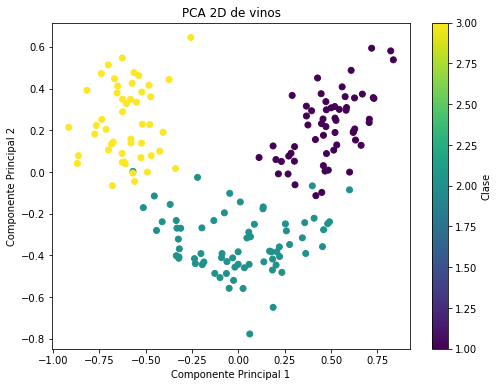

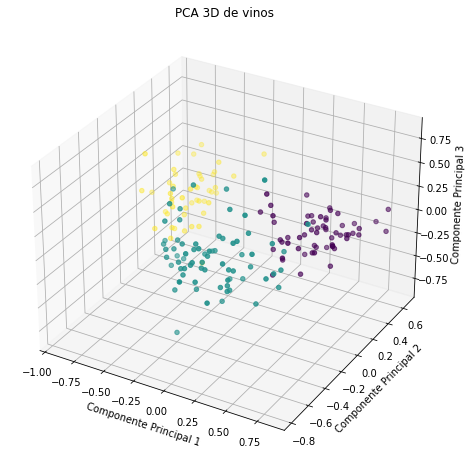

In [0]:
pca_vinos(vinos, is_3d= False)
pca_vinos(vinos, is_3d= True)


Análisis:
 - Se observan tres agrupaciones claras en el espacio bidimensional,
   correspondientes a las tres clases del conjunto de datos (representadas
   por los colores púrpura, verde azulado y amarillo).
 - El PCA logra capturar suficiente información para separar las clases
   utilizando solo los dos primeros componentes principales, lo que indica
   que estos concentran gran parte de la variabilidad del conjunto de datos.
 - Los clusters están bien definidos, lo que sugiere que los datos tienen
   patrones naturales que los diferencian y son representativos de las clases.
 - Este resultado indica que el PCA puede ser útil para reducir la dimensionalidad
   y visualizar los datos, además de preparar las entradas para modelos de clasificación.


### Histograma y boxplot

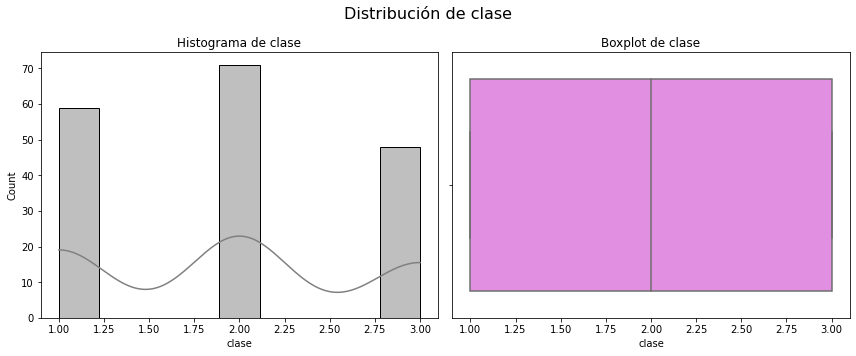

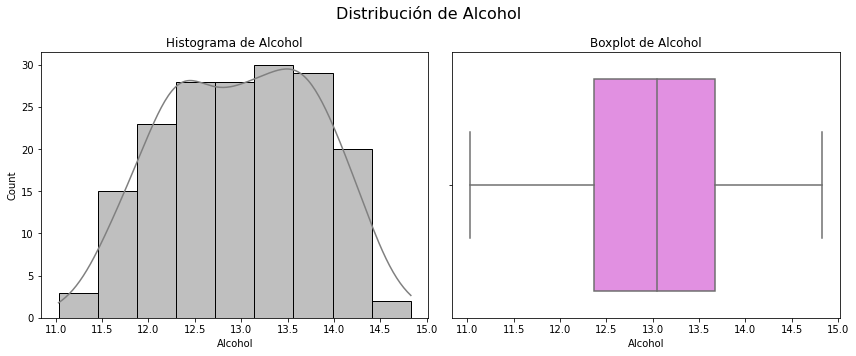

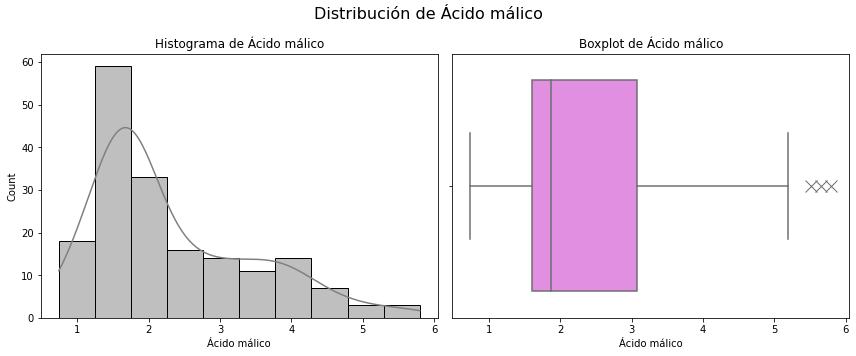

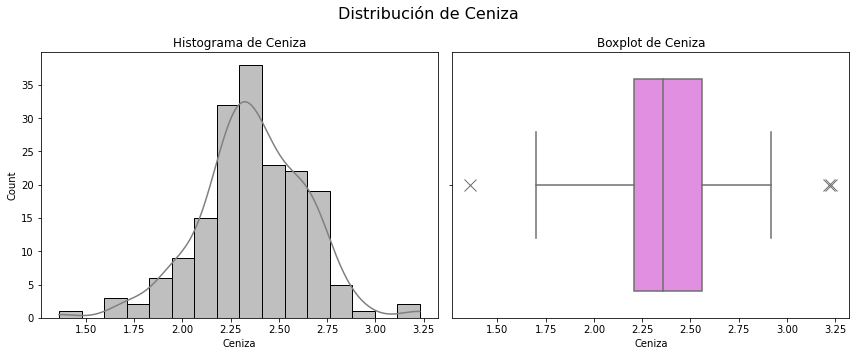

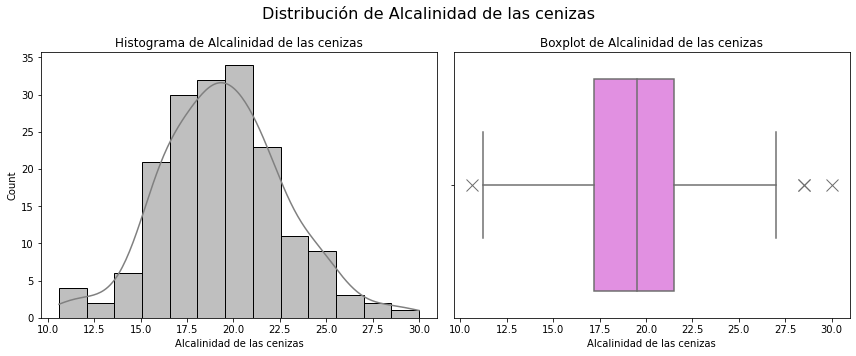

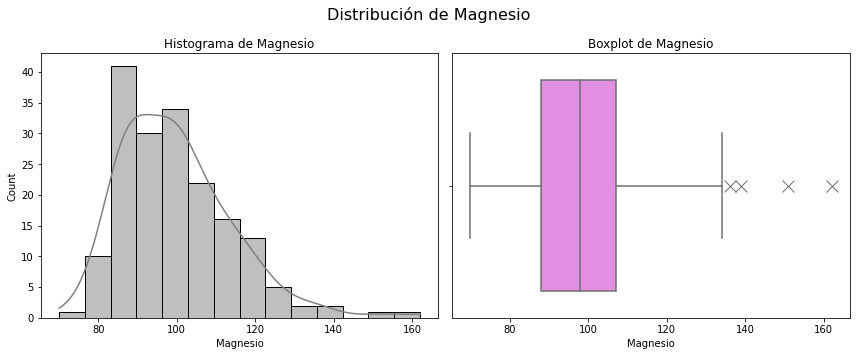

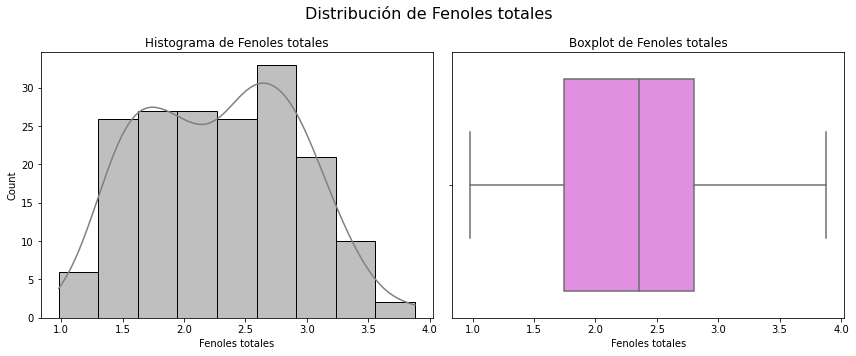

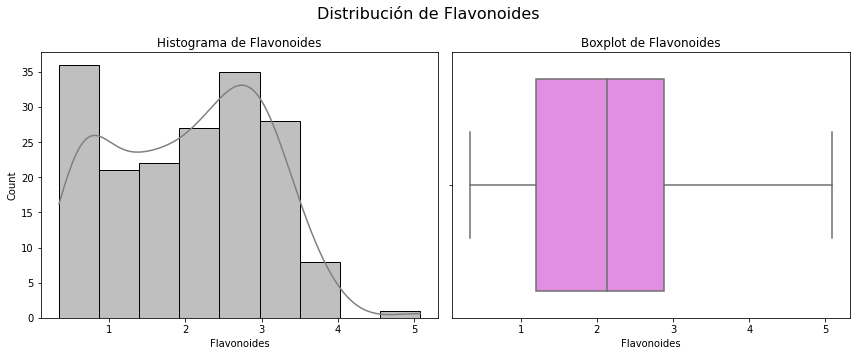

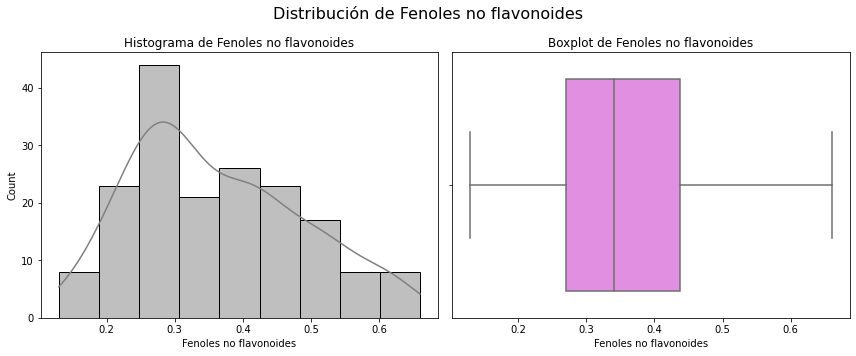

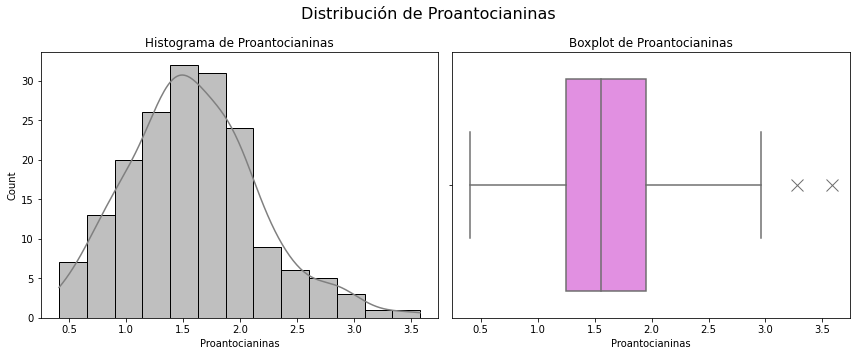

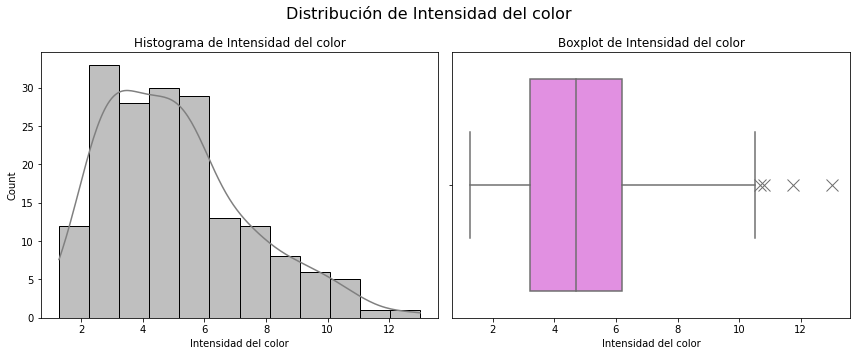

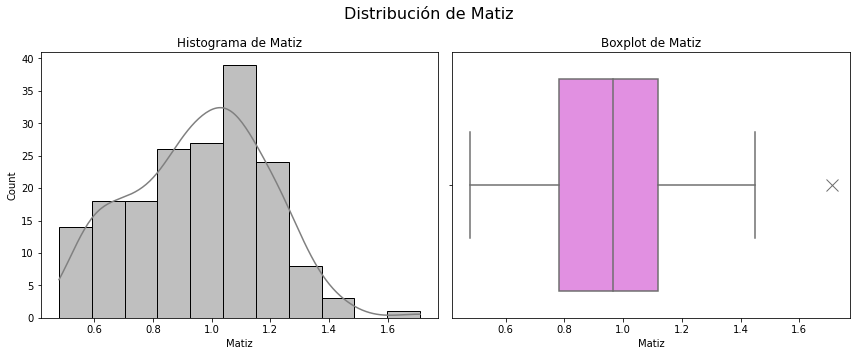

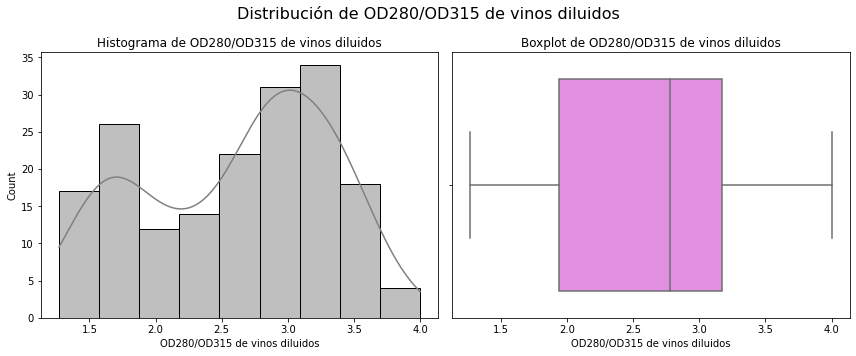

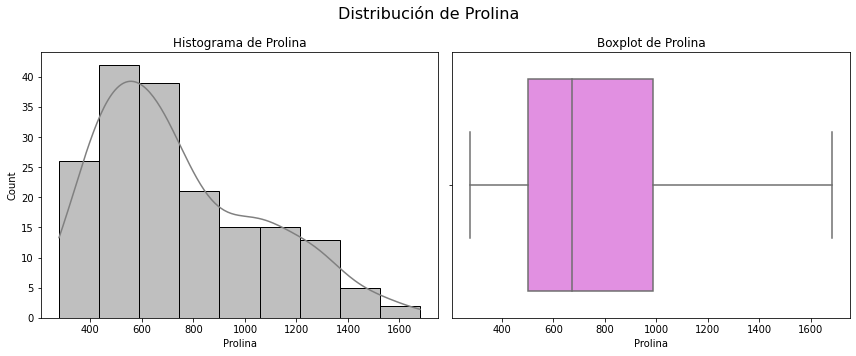

In [0]:
for columna in vinos.columns:
    plot_histograma_boxplot(vinos, columna)

### Revisión de outliers

In [0]:
outliers_df = pd.DataFrame()

for col in columnas:
    outliers = outliers_iqr(vinos,col)
    if not outliers.empty:
        print(f"Outliers en la columna '{col}':")
        print(outliers[[col]])
        print("-" * 20)
        outliers_df = pd.concat([outliers_df, outliers])


Outliers en la columna 'Ácido málico':
     Ácido málico
123          5.80
137          5.51
173          5.65
--------------------
Outliers en la columna 'Ceniza':
     Ceniza
25     3.22
59     1.36
121    3.23
--------------------
Outliers en la columna 'Alcalinidad de las cenizas':
     Alcalinidad de las cenizas
59                         10.6
73                         30.0
121                        28.5
127                        28.5
--------------------
Outliers en la columna 'Magnesio':
    Magnesio
69       151
73       139
78       136
95       162
--------------------
Outliers en la columna 'Proantocianinas':
     Proantocianinas
95              3.28
110             3.58
--------------------
Outliers en la columna 'Intensidad del color':
     Intensidad del color
151                 10.80
158                 13.00
159                 11.75
166                 10.68
--------------------
Outliers en la columna 'Matiz':
     Matiz
115   1.71
--------------------


Las columnas que tienen valores atipicos son:
- 'Ácido málico'
- 'Ceniza'
- 'Alcalinidad de la ceniza'
- 'Magnesio'
- 'Proantocianinas'
- 'Intensidad del color'
- 'Matiz'

In [0]:
# Se verifica si hay valores duplicados
vinos.duplicated().sum()

Out[14]: 0

In [0]:
# Visualización de los registros que contienen valores atipicos
outliers_df

,clase,Alcohol,Ácido málico,Ceniza,Alcalinidad de las cenizas,Magnesio,Fenoles totales,Flavonoides,Fenoles no flavonoides,Proantocianinas,Intensidad del color,Matiz,OD280/OD315 de vinos diluidos,Prolina
123,2,13.05,5.80,2.13,21.5,86,2.62,2.65,0.30,2.01,2.60,0.73,3.10,380
137,3,12.53,5.51,2.64,25.0,96,1.79,0.60,0.63,1.10,5.00,0.82,1.69,515
173,3,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740
25,1,13.05,2.05,3.22,25.0,124,2.63,2.68,0.47,1.92,3.58,1.13,3.20,830
59,2,12.37,0.94,1.36,10.6,88,1.98,0.57,0.28,0.42,1.95,1.05,1.82,520
121,2,11.56,2.05,3.23,28.5,119,3.18,5.08,0.47,1.87,6.00,0.93,3.69,465
59,2,12.37,0.94,1.36,10.6,88,1.98,0.57,0.28,0.42,1.95,1.05,1.82,520
73,2,12.99,1.67,2.60,30.0,139,3.30,2.89,0.21,1.96,3.35,1.31,3.50,985
121,2,11.56,2.05,3.23,28.5,119,3.18,5.08,0.47,1.87,6.00,0.93,3.69,465
127,2,11.79,2.13,2.78,28.5,92,2.13,2.24,0.58,1.76,3.00,0.97,2.44,466


In [0]:
outliers_df.index.unique().shape

Out[16]: (17,)

se eliminan los registros atipicos del dataframe

In [0]:
vinos_limpio = vinos.drop(outliers_df.index)

In [0]:
vinos_limpio.shape

Out[18]: (161, 14)

### Matriz de correlación

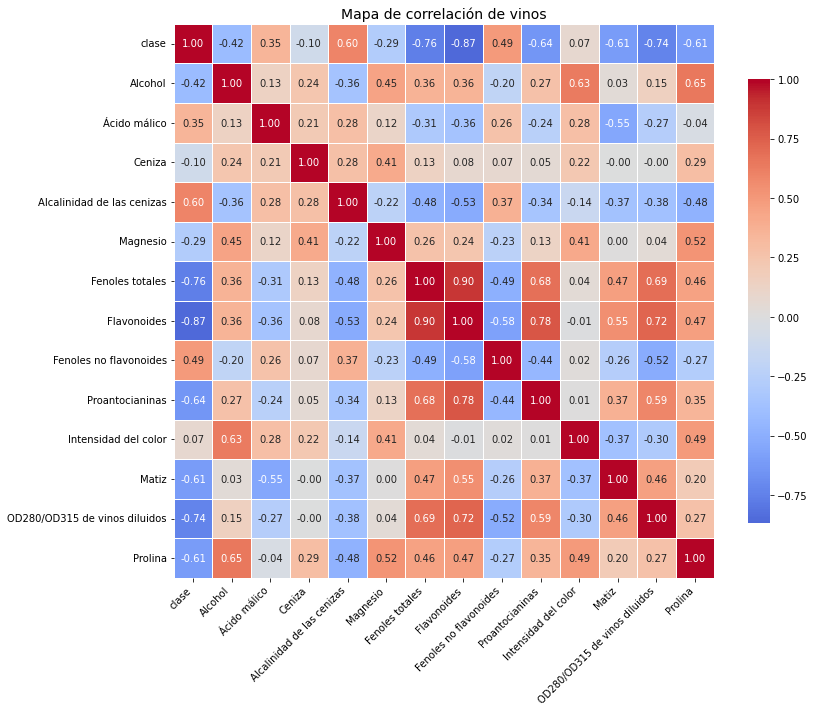

In [0]:
# Mapa de correlación con la clase objetivo o target
mapa_correlacion(vinos_limpio,columnas,'spearman','Mapa de correlación de vinos')

## Análisis
- **Variable objetivo**: `Clase` (que queremos predecir o clasificar).
- **Relaciones clave entre `Clase` y otras características**:
  - `Flavonoides`: Fuerte correlación negativa (~-0.87), lo que sugiere que es una característica muy informativa para distinguir entre clases.
  - `OD280/OD315 de vinos diluidos`: Alta correlación negativa (~-0.74), convirtiéndola en otra característica clave para la clasificación.
  - `Fenoles totales`: Correlación moderada negativa (~-0.76), indicando que también aporta información relevante para predecir la clase.
  - `Prolina`: Correlación moderada positiva (~0.65), siendo otra característica útil para diferenciar clases.
  
- **Redundancias observadas**:
  - `Flavonoides` y `Fenoles totales` tienen una alta correlación positiva entre sí (~0.90), lo que sugiere que podrían aportar información redundante. Podría ser eficiente seleccionar solo una de ellas dependiendo del contexto.

- **Conclusiones**:
  - Las características más correlacionadas con `Clase` son buenas candidatas para priorizarlas en modelos predictivos.
  - Las correlaciones fuertes entre variables no objetivo (por ejemplo, `Flavonoides` y `Fenoles totales`) podrían considerarse para evitar redundancias y mejorar la eficiencia del modelo.

## Modelos de Machine Learning

### Preparación de los datos

In [0]:
# Separación de los datos en etiquetas y variable objetivo
vino = vinos_limpio.copy()
# Dividir el DataFrame en características (X) y etiquetas (y)
X = vino.drop(columns='clase')  # Eliminar la columna 'clase' para obtener las características
y = vino['clase'] -1 # La columna 'clase' es la etiqueta




In [0]:

# Normalizar los datos
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

### XGBoost

In [0]:
# Definir el modelo de clasificación (XGBoost)
model = XGBClassifier()

# Parámetros para GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 9, 12]
}

# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=1)

# Entrenar el modelo con los mejores parámetros
grid_search.fit(X_train, y_train)

# Mejor modelo
best_model = grid_search.best_estimator_

# Realizar predicciones
y_pred = best_model.predict(X_test)

# Evaluar el modelo
print("Reporte de metricas:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Registrar el modelo en MLflow (sin Model Registry)
# Aquí usamos 'mlflow.sklearn' para registrar el modelo como artefacto
with mlflow.start_run(run_name="XGBoost_model"):
    # Registrar los mejores parámetros
    mlflow.log_params(grid_search.best_params_)
    
    # Registrar métricas de evaluación
    metrics = {
        "accuracy": np.mean(y_test == y_pred),
        "precision": classification_report(y_test, y_pred, output_dict=True)["weighted avg"]["precision"],
        "recall": classification_report(y_test, y_pred, output_dict=True)["weighted avg"]["recall"],
        "f1_score": classification_report(y_test, y_pred, output_dict=True)["weighted avg"]["f1-score"]
    }
    mlflow.log_metrics(metrics)
    
    # Crear un ejemplo de entrada para inferir la firma del modelo
    input_example = X_train[:1]  # Usar una muestra de los datos de entrenamiento como ejemplo
    
    # Registrar el modelo con la firma y el ejemplo de entrada
    mlflow.sklearn.log_model(
        sk_model=best_model,
        artifact_path="xgboost_model",
        pip_requirements=["xgboost==1.7.6", "scikit-learn==1.0.2", "cloudpickle==3.1.0"],
        input_example=input_example
    )

print("Modelo registrado en MLflow con firma y ejemplo de entrada.")

#  Predicción para nuevas muestras

muestras_a_predecir = np.array([[13.72, 1.43, 2.5, 16.7, 108, 3.4, 3.67, 0.19, 2.04, 6.8, 0.89, 2.87, 1285],
                  [12.37, 0.94, 1.36, 10.6, 88, 1.98, 0.57, 0.28, 0.42, 1.95, 1.05, 1.82, 520]])

# Otros datos para probar el modelo
# muestras_a_predecir = np.array([
#     [13.21, 1.15, 2.3, 14.9, 120, 3.1, 3.25, 0.18, 1.95, 6.1, 0.85, 2.56, 1200],
#     [12.5, 0.85, 1.5, 11.3, 95, 2.5, 0.6, 0.3, 0.35, 2.2, 1.0, 2.0, 550],
#     [14.0, 1.3, 2.8, 15.0, 110, 3.6, 3.5, 0.2, 2.1, 6.5, 0.8, 2.7, 1400],
#     [12.0, 0.9, 1.1, 10.0, 85, 2.2, 0.5, 0.3, 0.4, 2.0, 1.1, 1.8, 600],
#     [13.5, 1.2, 2.4, 14.0, 100, 3.2, 3.0, 0.15, 1.8, 6.0, 0.9, 2.65, 1300],
#     [12.56, 2.15, 2.38, 21.50, 96.35, 2.40, 2.13, 0.39, 1.70, 3.20, 1.10, 2.87, 510],
#     [12.48, 1.98, 2.28, 19.80, 92.70, 2.10, 2.00, 0.35, 1.62, 3.05, 1.08, 2.77, 522],
#     [12.33,	1.10, 2.28,	16.0, 101.0, 2.05, 1.09, 0.63, 0.9, 3.27, 1.25, 1.67, 680.0],
#     [12.51 ,1.24, 2.25, 17.5, 85.0, 2.0, 0.58, 0.6, 1.25, 5.45, 0.75, 1.51, 650.0],
#     [12.45 ,1.35, 2.1, 17.9, 85.2, 2.9, 0.65, 0.8, 1.20, 5.2, 0.8, 1.81, 650.0],
#     [12.45 ,1.35, 2.1, 17.9, 85.2, 2.9, 0.65, 0.8, 1.20, 5.2, 0.8, 1.81, 680.0],
#     [12.45 ,1.35, 2.1, 17.9, 101.2, 2.9, 0.65, 0.8, 1.20, 5.2, 0.8, 1.81, 650.0],
#     [12.45 ,1.35, 2.1, 17.9, 101.2, 2.9, 0.65, 0.8, 1.20, 5.2, 0.8, 1.81, 680.0]

# ])

# 
# Convertir las nuevas muestras a DataFrame para asegurar los nombres de columna
muestras_a_predecir_df = pd.DataFrame(muestras_a_predecir, columns=X.columns)

# Preprocesar las nuevas muestras (escalar)
muestras_a_predecir_scaled = scaler.transform(muestras_a_predecir_df)

# Realizar la predicción
predicciones = best_model.predict(muestras_a_predecir_scaled)

# Mostrar el resultado de las predicciones
print(f"Predicciones para las nuevas muestras: {predicciones}")

# Definir el directorio donde se va a guardar el archivo CSV
dir_path = '/dbfs/tmp'

# Verificar si el directorio existe, si no, crear
if not os.path.exists(dir_path):
    os.makedirs(dir_path)

# Guardar las predicciones en un DataFrame

predicciones_df = pd.DataFrame({
    "Muestra": [f"Muestra {i+1}" for i in range(len(muestras_a_predecir))],
    "Predicción": predicciones
})

# Ruta completa del archivo CSV
predictions_file = os.path.join(dir_path, 'xgboost_predictions.csv')

# Guardar el DataFrame como archivo CSV en el directorio
predicciones_df.to_csv(predictions_file, index=False)

# Usar MLflow para registrar el archivo CSV como artefacto
with mlflow.start_run(run_name="XGBoost_Model_Predictions"):
    mlflow.log_artifact(predictions_file)

print("Predicciones guardadas y registradas como artefacto.")

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Reporte de metricas:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      0.92      0.96        13
           2       0.88      1.00      0.93         7

    accuracy                           0.97        33
   macro avg       0.96      0.97      0.96        33
weighted avg       0.97      0.97      0.97        33

Confusion Matrix:
[[13  0  0]
 [ 0 12  1]
 [ 0  0  7]]


2024/12/05 16:40:37 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - scikit-learn (current: 1.5.2, required: scikit-learn==1.0.2)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2024/12/05 16:40:37 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - scikit-learn (current: 1.5.2, required: scikit-learn==1.0.2)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.


🏃 View run XGBoost_model at: https://community.cloud.databricks.com/ml/experiments/1527383825511391/runs/664dcb9cbb954ed98a3b83406022d335
🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/1527383825511391
Modelo registrado en MLflow con firma y ejemplo de entrada.
Predicciones para las nuevas muestras: [0 1]
🏃 View run XGBoost_Model_Predictions at: https://community.cloud.databricks.com/ml/experiments/1527383825511391/runs/b4e462926159458b9eedc359ca40b742
🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/1527383825511391
Predicciones guardadas y registradas como artefacto.


## K-Means

In [0]:
#vinos_limpio.drop(columns= 'Cluster', inplace=True)

In [0]:
# Escalar los datos
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(vinos_limpio.iloc[:, 1:])  # Ajusta las columnas según tu dataset

# Convertir X_scaled a DataFrame para mantener los nombres de las columnas
X_scaled_df = pd.DataFrame(X_scaled, columns=vinos_limpio.columns[1:])

# Finalizar el run anterior si está activo
if mlflow.active_run():
    mlflow.end_run()
# Iniciar un experimento de MLflow
with mlflow.start_run(run_name="KMeans_model"):

    # Entrenar el modelo KMeans
    kmeans = KMeans(n_clusters=3, random_state=42)
    vinos_limpio['Cluster'] = kmeans.fit_predict(X_scaled_df)  # Usar X_scaled_df con nombres de columnas

    # Registrar el modelo KMeans en MLflow
    mlflow.log_param("n_clusters", 3)  # Registrar el número de clusters


    muestras_a_predecir = np.array([
    [13.21, 1.15, 2.3, 14.9, 120, 3.1, 3.25, 0.18, 1.95, 6.1, 0.85, 2.56, 1200],
    [12.5, 0.85, 1.5, 11.3, 95, 2.5, 0.6, 0.3, 0.35, 2.2, 1.0, 2.0, 550],
    [14.0, 1.3, 2.8, 15.0, 110, 3.6, 3.5, 0.2, 2.1, 6.5, 0.8, 2.7, 1400],
    [12.0, 0.9, 1.1, 10.0, 85, 2.2, 0.5, 0.3, 0.4, 2.0, 1.1, 1.8, 600],
    [13.5, 1.2, 2.4, 14.0, 100, 3.2, 3.0, 0.15, 1.8, 6.0, 0.9, 2.65, 1300],
    [12.56, 2.15, 2.38, 21.50, 96.35, 2.40, 2.13, 0.39, 1.70, 3.20, 1.10, 2.87, 510],
    [12.48, 1.98, 2.28, 19.80, 92.70, 2.10, 2.00, 0.35, 1.62, 3.05, 1.08, 2.77, 522],
    [12.33,	1.10, 2.28,	16.0, 101.0, 2.05, 1.09, 0.63, 0.9, 3.27, 1.25, 1.67, 680.0],
    [12.51 ,1.24, 2.25, 17.5, 85.0, 2.0, 0.58, 0.6, 1.25, 5.45, 0.75, 1.51, 650.0],
    [12.45 ,1.35, 2.1, 17.9, 85.2, 2.9, 0.65, 0.8, 1.20, 5.2, 0.8, 1.81, 650.0],
    [12.45 ,1.35, 2.1, 17.9, 85.2, 2.9, 0.65, 0.8, 1.20, 5.2, 0.8, 1.81, 680.0],
    [12.45 ,1.35, 2.1, 17.9, 101.2, 2.9, 0.65, 0.8, 1.20, 5.2, 0.8, 1.81, 650.0],
    [12.45 ,1.35, 2.1, 17.9, 101.2, 2.9, 0.65, 0.8, 1.20, 5.2, 0.8, 1.81, 680.0]

])
    
    # Convertir las nuevas muestras a DataFrame para asegurar los nombres de columna
    muestras_a_predecir_df = pd.DataFrame(muestras_a_predecir)

    # Preprocesar las nuevas muestras (escalar)
    muestras_a_predecir_scaled = scaler.transform(muestras_a_predecir_df)
    
    # Asegúrate de que el modelo esté usando las características con nombres al predecir
    predicciones = kmeans.predict(muestras_a_predecir_scaled)

    # Crear un DataFrame con las predicciones
    df_predicciones = pd.DataFrame(muestras_a_predecir, columns=vinos_limpio.columns[1:-1])
    df_predicciones['Cluster'] = predicciones

    # Registrar las predicciones en MLflow
    mlflow.log_param("num_samples_predicted", len(muestras_a_predecir))
    mlflow.log_metric("cluster_0_count", sum(predicciones == 0))
    mlflow.log_metric("cluster_1_count", sum(predicciones == 1))
    mlflow.log_metric("cluster_2_count", sum(predicciones == 2))

    # Registrar el ejemplo de entrada y la firma del modelo
    input_example = pd.DataFrame([muestras_a_predecir[0]], columns=vinos_limpio.columns[1:-1])
    signature = infer_signature(input_example, kmeans.predict(input_example))
    
    # Guardar el modelo con la firma
    mlflow.sklearn.log_model(kmeans, "kmeans_model", signature=signature, input_example=input_example, pip_requirements=["scikit-learn==1.0.2", "cloudpickle==3.1.0"])

    # Imprimir resultados
    print("Modelo y resultados registrados en MLflow.")
    print(df_predicciones[['Cluster']])

# Guardar las predicciones en un DataFrame
predicciones_df = pd.DataFrame({
    "Muestra": [f"Muestra {i+1}" for i in range(len(muestras_a_predecir))],
    "Predicción": predicciones
})
# predicciones_df = pd.DataFrame(predicciones, columns=["Predicción"])

# Guardar el DataFrame como archivo CSV localmente
predictions_file = '/dbfs/tmp/KMeans_predictions.csv'
predicciones_df.to_csv(predictions_file, index=False)

# Usar MLflow para registrar el archivo CSV como artefacto
with mlflow.start_run(run_name="KMeans_Predictions"):
    mlflow.log_artifact(predictions_file)

print(f"Predicciones guardadas en: {predictions_file}")


2024/12/05 16:40:40 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - scikit-learn (current: 1.5.2, required: scikit-learn==1.0.2)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2024/12/05 16:40:40 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - scikit-learn (current: 1.5.2, required: scikit-learn==1.0.2)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.


Modelo y resultados registrados en MLflow.
    Cluster
0         2
1         0
2         2
3         0
4         2
5         0
6         0
7         0
8         1
9         1
10        1
11        1
12        1
🏃 View run KMeans_model at: https://community.cloud.databricks.com/ml/experiments/1527383825511391/runs/7f2ef738db99419eb7318427e8381675
🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/1527383825511391
🏃 View run KMeans_Predictions at: https://community.cloud.databricks.com/ml/experiments/1527383825511391/runs/107a6f50bb374403b1c72bcd0b2b7fc1
🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/1527383825511391
Predicciones guardadas en: /dbfs/tmp/KMeans_predictions.csv


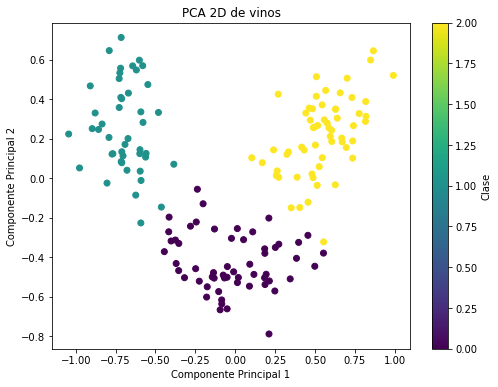

In [0]:
pca_vinos(vinos_limpio.drop(columns='clase'), target_column='Cluster', is_3d=False)

## Redes Neuronales

In [0]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Crear el modelo de red neuronal
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))  # Capa de entrada
model.add(Dense(32, activation='relu'))  # Capa oculta
model.add(Dense(3, activation='softmax'))  # Capa de salida (3 clases)

# Compilar el modelo
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Configura early stopping y guardar el mejor modelo
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Entrenar el modelo
model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test),
          callbacks=[early_stopping, model_checkpoint], verbose=1)

# Evaluar el modelo
y_pred = np.argmax(model.predict(X_test), axis=1)

# Imprimir el reporte de clasificación
print("Reporte de metricas:")
print(classification_report(y_test, y_pred))

# Imprimir la matriz de confusión
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Finalizar el run anterior si está activo
if mlflow.active_run():
    mlflow.end_run()
# Registrar el modelo en MLflow
with mlflow.start_run(run_name="Redes neuronales"):
    # Registrar los parámetros
    mlflow.log_param("epochs", 50)
    mlflow.log_param("batch_size", 16)
    
    # Registrar las métricas de evaluación
    report = classification_report(y_test, y_pred, output_dict=True)
    mlflow.log_metric("accuracy", report["accuracy"])
    mlflow.log_metric("precision", report["weighted avg"]["precision"])
    mlflow.log_metric("recall", report["weighted avg"]["recall"])
    mlflow.log_metric("f1_score", report["weighted avg"]["f1-score"])

    # Registrar el modelo Keras
    input_example = np.array([X_train[0]])  # Tomamos un ejemplo de los datos de entrenamiento
    mlflow.keras.log_model(model, "neural_network_model", input_example=input_example)

print("Modelo registrado en MLflow con red neuronal.")

# Predicción para nuevas muestras
muestras_a_predecir = np.array([[13.72, 1.43, 2.5, 16.7, 108, 3.4, 3.67, 0.19, 2.04, 6.8, 0.89, 2.87, 1285],
                        [12.37, 0.94, 1.36, 10.6, 88, 1.98, 0.57, 0.28, 0.42, 1.95, 1.05, 1.82, 520]])


# Convertir las nuevas muestras a DataFrame para asegurar los nombres de columna
muestras_a_predecir_df = pd.DataFrame(muestras_a_predecir, columns=X.columns)

# Preprocesar las nuevas muestras (escalar)
muestras_a_predecir_scaled = scaler.transform(muestras_a_predecir_df)

# Realizar la predicción
predicciones = np.argmax(model.predict(muestras_a_predecir_scaled,  batch_size=1), axis=1)

# Mostrar el resultado de las predicciones
print(f"Predicciones para las nuevas muestras: {predicciones}")


# Guardar las predicciones en un DataFrame
predicciones_df = pd.DataFrame({
    "Muestra": [f"Muestra {i+1}" for i in range(len(muestras_a_predecir))],
    "Predicción": predicciones
})
# predicciones_df = pd.DataFrame(predicciones, columns=["Predicción"])

# Guardar el DataFrame como archivo CSV localmente
predictions_file = '/dbfs/tmp/neural_network_predictions.csv'
predicciones_df.to_csv(predictions_file, index=False)

# Usar MLflow para registrar el archivo CSV como artefacto
with mlflow.start_run(run_name="Neural_Network_Model_Predictions"):
    mlflow.log_artifact(predictions_file)

print(f"Predicciones guardadas en: {predictions_file}")





Epoch 1/50
8/8 [==============================] - 1s 40ms/step - loss: 1.0592 - accuracy: 0.4453 - val_loss: 0.9888 - val_accuracy: 0.6970
Epoch 2/50
8/8 [==============================] - 0s 11ms/step - loss: 0.9736 - accuracy: 0.6719 - val_loss: 0.9102 - val_accuracy: 0.7576
Epoch 3/50
8/8 [==============================] - 0s 10ms/step - loss: 0.9137 - accuracy: 0.6406 - val_loss: 0.8426 - val_accuracy: 0.7576
Epoch 4/50
8/8 [==============================] - 0s 11ms/step - loss: 0.8500 - accuracy: 0.7188 - val_loss: 0.7806 - val_accuracy: 0.8182
Epoch 5/50
8/8 [==============================] - 0s 12ms/step - loss: 0.7837 - accuracy: 0.8438 - val_loss: 0.7167 - val_accuracy: 0.8788
Epoch 6/50
8/8 [==============================] - 0s 12ms/step - loss: 0.7196 - accuracy: 0.8750 - val_loss: 0.6525 - val_accuracy: 0.8788
Epoch 7/50
8/8 [==============================] - 0s 9ms/step - loss: 0.6552 - accuracy: 0.9062 - val_loss: 0.5881 - val_accuracy: 0.8788
Epoch 8/50
8/8 [============

INFO:tensorflow:Assets written to: /local_disk0/repl_tmp_data/ReplId-6c38d-df83e-fc504-8/tmpmmpu9ztq/model/data/model/assets


INFO:tensorflow:Assets written to: /local_disk0/repl_tmp_data/ReplId-6c38d-df83e-fc504-8/tmpmmpu9ztq/model/data/model/assets
2024/12/05 16:40:58 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /local_disk0/repl_tmp_data/ReplId-6c38d-df83e-fc504-8/tmpmmpu9ztq/model, flavor: tensorflow). Fall back to return ['tensorflow==2.12.0', 'cloudpickle==3.1.0']. Set logging level to DEBUG to see the full traceback. 


1/1 [==============================] - 0s 64ms/step
🏃 View run Redes neuronales at: https://community.cloud.databricks.com/ml/experiments/1527383825511391/runs/0cd168fe764d421eb0e2972234bea089
🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/1527383825511391
Modelo registrado en MLflow con red neuronal.
2/2 [==============================] - 0s 6ms/step
Predicciones para las nuevas muestras: [0 1]
🏃 View run Neural_Network_Model_Predictions at: https://community.cloud.databricks.com/ml/experiments/1527383825511391/runs/e75a6769427548b2a4f20a6a7b9ef9fe
🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/1527383825511391
Predicciones guardadas en: /dbfs/tmp/neural_network_predictions.csv


## Maquina de soporte vectorial

In [0]:
from sklearn.svm import SVC
# Crear y entrenar el modelo SVM
model = SVC(kernel='linear', random_state=42, probability =True)
model.fit(X_train, y_train)

# Evaluar el modelo
y_pred = model.predict(X_test)
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred))
print("Matriz de confusión:")
print(confusion_matrix(y_test, y_pred))


# Finalizar el run anterior si está activo
if mlflow.active_run():
    mlflow.end_run()
# Registrar el experimento con MLflow
with mlflow.start_run(run_name='Maquina_de_soporte_vectorial'):
    mlflow.log_param('kernel', 'linear')
    mlflow.log_metric('accuracy', model.score(X_test, y_test))
    mlflow.sklearn.log_model(model, 'svm_model')

# Nuevas muestras de vino para la predicción
    new_samples = [
    [13.72, 1.43, 2.5, 16.7, 108, 3.4, 3.67, 0.19, 2.04, 6.8, 0.89, 2.87, 1285],
    [12.37, 0.94, 1.36, 10.6, 88, 1.98, 0.57, 0.28, 0.42, 1.95, 1.05, 1.82, 520]
    ]
# Escalar las nuevas muestras
new_samples_scaled = scaler.transform(new_samples)

# Realizar predicción
predictions = model.predict(new_samples_scaled)
print("Predicciones para las nuevas muestras:", predictions)

# Imprimir las probabilidades de las predicciones
probabilities = model.predict_proba(new_samples_scaled)
print("\nProbabilidades de las predicciones:")
print(probabilities)

# Crear DataFrame para las probabilidades
probabilities_df = pd.DataFrame(probabilities, columns=["Probabilidad Clase 0", "Probabilidad Clase 1", "Probabilidad Clase 2"])

# Crear DataFrame para las predicciones
predictions_df = pd.DataFrame({
    "Muestra": [f"Muestra {i+1}" for i in range(len(new_samples))],
    "Predicción": predictions
})

# Guardar ambos DataFrames como archivos CSV locales
probabilities_file = '/dbfs/tmp/svm_probabilities.csv'
predictions_file = '/dbfs/tmp/svm_predictions.csv'

probabilities_df.to_csv(probabilities_file, index=False)
predictions_df.to_csv(predictions_file, index=False)

# Registrar los archivos CSV como artefactos en MLflow
# Usar MLflow para registrar el archivo CSV como artefacto
with mlflow.start_run(run_name="Maquina_de_soporte_vectorial_Predictions"):
    mlflow.log_artifact(predictions_file)
    mlflow.log_artifact(probabilities_file)

print(f"Probabilidades guardadas en: {probabilities_file}")
print(f"Predicciones guardadas en: {predictions_file}")

Reporte de clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      0.92      0.96        13
           2       0.88      1.00      0.93         7

    accuracy                           0.97        33
   macro avg       0.96      0.97      0.96        33
weighted avg       0.97      0.97      0.97        33

Matriz de confusión:
[[13  0  0]
 [ 0 12  1]
 [ 0  0  7]]


2024/12/05 16:41:03 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /local_disk0/repl_tmp_data/ReplId-6c38d-df83e-fc504-8/tmpj59eapes/model/model.pkl, flavor: sklearn). Fall back to return ['scikit-learn==1.5.2', 'cloudpickle==3.1.0']. Set logging level to DEBUG to see the full traceback. 
2024/12/05 16:41:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run Maquina_de_soporte_vectorial at: https://community.cloud.databricks.com/ml/experiments/1527383825511391/runs/4cb0ccb418d5473994fc59d67a782ce8
🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/1527383825511391
Predicciones para las nuevas muestras: [0 1]

Probabilidades de las predicciones:
[[0.99643352 0.00158311 0.00198337]
 [0.00259704 0.98128745 0.01611551]]
🏃 View run Maquina_de_soporte_vectorial_Predictions at: https://community.cloud.databricks.com/ml/experiments/1527383825511391/runs/532091db9ba24e438b93d9f71592ef05
🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/1527383825511391
Probabilidades guardadas en: /dbfs/tmp/svm_probabilities.csv
Predicciones guardadas en: /dbfs/tmp/svm_predictions.csv
